# Hill climbing art

In [1]:
import random
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops

In [2]:
SAVE_FIGS = True

SEED = 1111
random.seed(SEED)
np.random.seed(SEED)

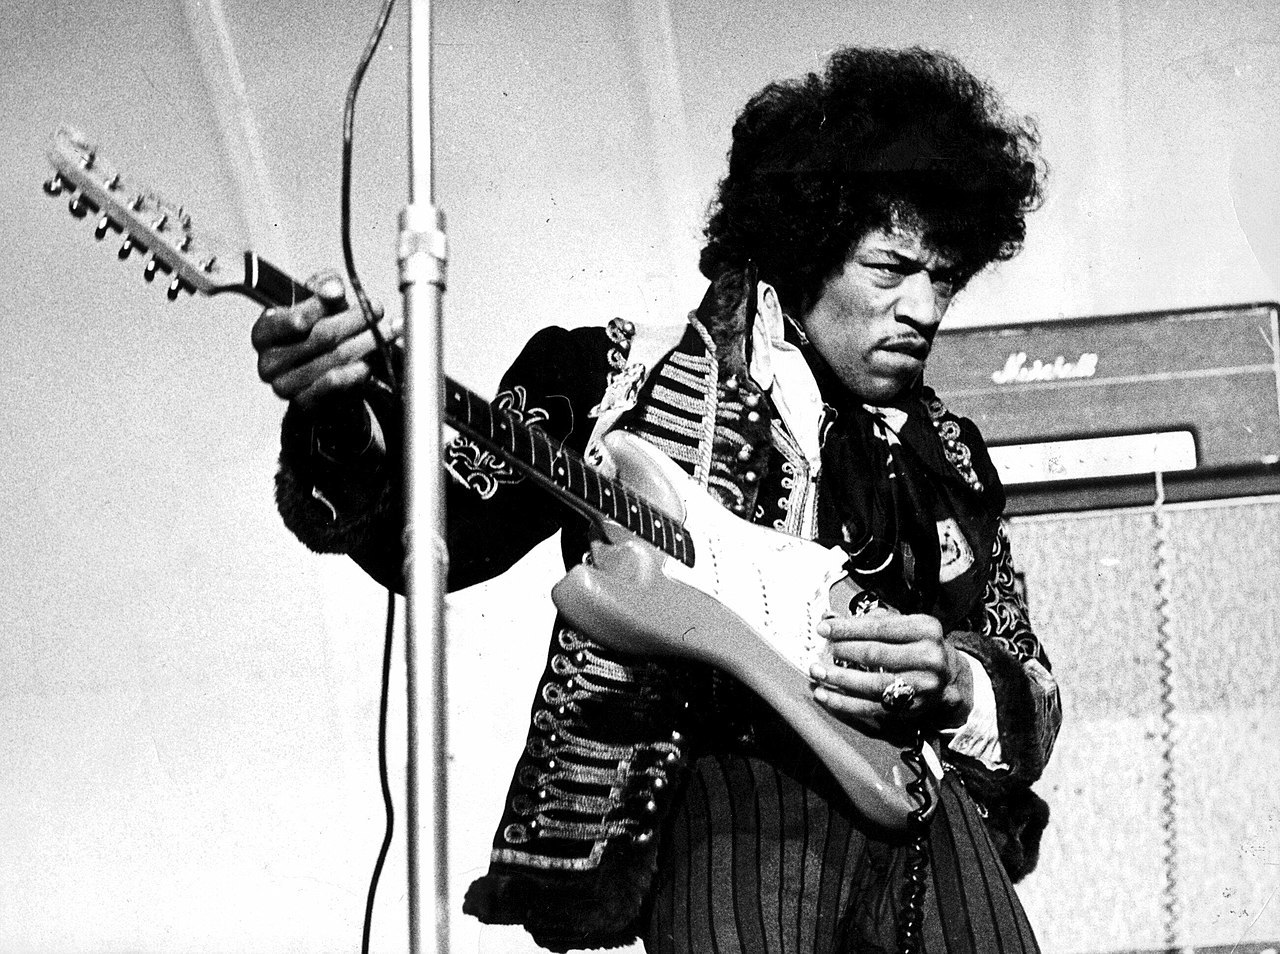

In [3]:
# open the target image
target_image_path = 'images/Jimi_Hendrix_1967_uncropped.jpg'
im_target = Image.open(target_image_path).convert('L')
im_target

[Source](https://commons.wikimedia.org/wiki/File:Jimi_Hendrix_1967_uncropped.jpg)

In [4]:
np.asarray(im_target)

array([[153, 133, 133, ..., 187, 196, 187],
       [155, 152, 137, ..., 190, 195, 188],
       [160, 158, 155, ..., 190, 193, 173],
       ...,
       [233, 243, 244, ..., 157, 140, 120],
       [235, 237, 237, ..., 157, 112, 109],
       [233, 235, 235, ..., 143,  94,  88]], dtype=uint8)

In [5]:
print(np.asarray(im_target).shape)
print(np.asarray(im_target).T.shape == im_target.size)

(954, 1280)
True


In [6]:
im_target.size

(1280, 954)

draw a circle on our generated image using `ImageDraw`. 

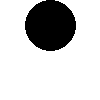

In [7]:
# image with a black circle
im1 = Image.new(mode='L', size=(100, 100), color=255)

draw = ImageDraw.Draw(im1)
draw.ellipse(xy=((25, 0), # starting coordinate
                 (75, 50)), # ending coordinate
             fill=0)
if SAVE_FIGS: 
    im1.save('images/black_circle.jpg')
im1

### Image comparison

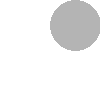

In [8]:
# image to compare with im1
im2 = Image.new(mode='L', size=(100, 100), color=255)
draw = ImageDraw.Draw(im2)
draw.ellipse(xy=((50, 0), # starting coordinate
                 (100, 50)), # ending coordinate
             fill=180)

if SAVE_FIGS: 
    im2.save('images/gray_circle.jpg')
im2

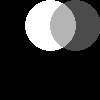

In [9]:
if SAVE_FIGS: 
    ImageChops.difference(im1, im2).save('images/circle_diff.jpg')
im_diff = ImageChops.difference(im1, im2)
im_diff

What's the average difference of these images? 

In [10]:
array_diff = np.asarray(im_diff)
percent_diff = array_diff.mean() / 255  # standardize to percent terms
print(f'im1 and im2 are {round(percent_diff * 100, 2)}% different')

im1 and im2 are 21.44% different


In [11]:
def find_img_diff_pct(im1: Image.Image, im2: Image.Image) -> float:
    assert im1.size == im2.size
    return np.asarray(ImageChops.difference(im1, im2)).mean() / 255

### Drawing random circles

In [12]:
CIRCLE_START_RADIUS = 100
CIRCLE_END_RADIUS = 4
CIRCLE_PERCENT_VARIANCE = 0.2

In [13]:
def choose_circle_radius(percent_complete: float) -> float:
    alpha = alpha_func(percent_complete)
    circle_radius_target = int(CIRCLE_START_RADIUS - (CIRCLE_START_RADIUS - CIRCLE_END_RADIUS) * alpha)
    # add a bit of variance to the circle radius
    circle_radius = int(random.uniform(1 - CIRCLE_PERCENT_VARIANCE,
                                           1 + CIRCLE_PERCENT_VARIANCE) * circle_radius_target)
    return circle_radius

In [14]:
def alpha_func(x: float) -> float:
    """x in range [0, 1] returns range [0, 1]"""
    assert 0 <= x <= 1
    # return x  # linear: for x in [0, 1] just returns x
    return loglike(x)

def loglike(x: float, stretch: int = 40) -> float:
    return np.log((x * stretch) + 1) / np.log(stretch + 1)

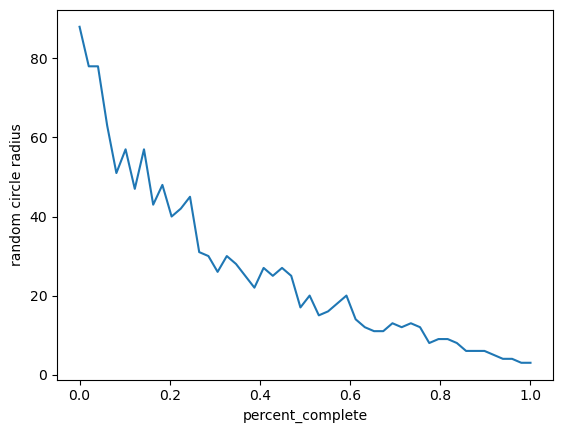

In [15]:
x = np.linspace(0, 1)
y = [choose_circle_radius(_x) for _x in x]

plt.plot(x, y)
plt.xlabel('percent_complete')
plt.ylabel('random circle radius')
if SAVE_FIGS: 
    plt.savefig('images/circle_radius.jpg')
plt.show()

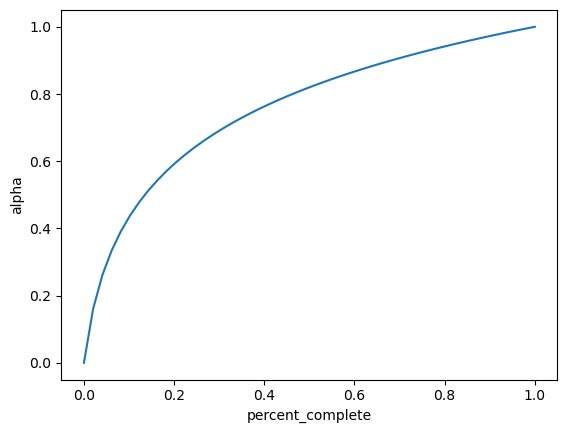

In [16]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1)
y = loglike(x)

plt.plot(x, y)
plt.xlabel('percent_complete')
plt.ylabel('alpha')
if SAVE_FIGS:
    plt.savefig('images/alpha.jpg')
plt.show()

## complete code

epoch: 0, difference: 0.3492539346713528
epoch: 10000, difference: 0.11385856635631192
epoch: 20000, difference: 0.10548068054527891
epoch: 30000, difference: 0.0974889815071731
epoch: 40000, difference: 0.09126970547128704
epoch: 50000, difference: 0.08784024052493114
epoch: 60000, difference: 0.0839930876700785
epoch: 70000, difference: 0.080742144145394
epoch: 80000, difference: 0.07778092821247996
epoch: 90000, difference: 0.07505323945615983
epoch: 100000, difference: 0.07270399787273399
number of good guesses: 3940
good guess percent: 0.0394
Total time: 6.09 min


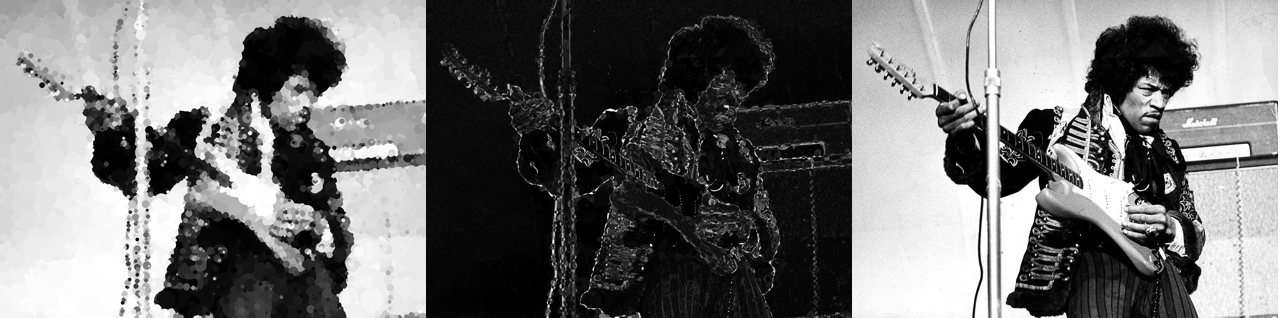

In [17]:
import random
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops

SAVE_FIGS = True

BLACK = 0
WHITE = 255

CIRCLE_START_RADIUS = 100
CIRCLE_END_RADIUS = 4
CIRCLE_PERCENT_VARIANCE = 0.2

MAX_ITERATIONS = 100_000

# for reproducibility
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)


def find_img_diff_pct(im1: Image.Image, im2: Image.Image) -> float:
    assert im1.size == im2.size
    return np.asarray(ImageChops.difference(im1, im2)).mean() / 255

def choose_circle_radius(percent_complete: float) -> float:
    alpha = alpha_func(percent_complete)
    circle_radius_target = int(CIRCLE_START_RADIUS - (CIRCLE_START_RADIUS - CIRCLE_END_RADIUS) * alpha)
    # add a bit of variance to the circle radius
    circle_radius = int(random.uniform(1 - CIRCLE_PERCENT_VARIANCE,
                                           1 + CIRCLE_PERCENT_VARIANCE) * circle_radius_target)
    return circle_radius

def alpha_func(x: float) -> float:
    """x in range [0, 1] returns range [0, 1]"""
    assert 0 <= x <= 1
    # return x  # linear: for x in [0, 1] just returns x
    return loglike(x)

def loglike(x: float, stretch: int = 40) -> float:
    return np.log((x * stretch) + 1) / np.log(stretch + 1)


# open the target image
target_image_path = 'images/Jimi_Hendrix_1967_uncropped.jpg'
im_target = Image.open(target_image_path).convert('L')
np_target = np.array(im_target)

X_MAX = im_target.size[0]
Y_MAX = im_target.size[1]

# initial blank starting image
im_generated = Image.new(mode='L', size=im_target.size, color=WHITE)

# 1 initial difference
diff_generated_init = find_img_diff_pct(im_generated, im_target)
diff_generated = diff_generated_init
diff_compare = diff_generated

num_pixels = np.ones(im_target.size).size

# keep track of progress
diff_list = []
guess_diff_list = []
good_guess_pct_list = []

good_guesses = 0
epoch = 0

# time progress
t0 = perf_counter()

while epoch < MAX_ITERATIONS:
    # random radius
    circle_radius = choose_circle_radius(epoch / MAX_ITERATIONS)

    # random center point
    circle_center_x = random.randrange(0, X_MAX)
    circle_center_y = random.randrange(0, Y_MAX)
    # start/end points as (x, y)
    circle_start_point = (circle_center_x - circle_radius, circle_center_y - circle_radius)
    circle_stop_point = (circle_center_x + circle_radius, circle_center_y + circle_radius)
    
    # random color
    circle_color = random.randrange(BLACK, WHITE+1, 1)
    
    # copy current working image
    im_compare = ImageChops.duplicate(im_generated)
    # draw a random shape on it
    draw = ImageDraw.Draw(im_compare)
    draw.ellipse((circle_start_point, circle_stop_point), fill=circle_color)

    # find difference of new im_compare with target
    diff_compare = find_img_diff_pct(im_target, im_compare)
    
    # if new image is less different than target
    if diff_compare < diff_generated:
        # switch working image to the new im_compare
        im_generated = ImageChops.duplicate(im_compare)
        diff_generated = diff_compare
        good_guesses += 1
    # else just keep the working image without the random shape
    
    # print progress
    if epoch % 10_000 == 0:
    # if epoch % 2500 == 0:
        print(f'epoch: {epoch}, difference: {diff_generated}')

    epoch += 1

    diff_list.append(diff_generated)
    guess_diff_list.append(diff_compare)
    good_guess_pct_list.append(good_guesses / epoch)
    
t1 = perf_counter()

print(f'epoch: {epoch}, difference: {diff_generated}')
print(f'number of good guesses: {good_guesses}')
print(f'good guess percent: {good_guesses / epoch}')
print(f'Total time: {round((t1 - t0) / 60, 2)} min')

# combine the generated, difference, and target images for easier viewing
im_diff = ImageChops.difference(im_target, im_generated)
new_size = (int(im_target.size[0]/3), int(im_target.size[1]/3))
im_display = Image.new('L', (im_target.size[0], new_size[1]), 255)
im_display.paste(im_generated.resize(new_size), (0, 0))
im_display.paste(im_diff.resize(new_size), (new_size[0], 0))
im_display.paste(im_target.resize(new_size), (new_size[0]*2, 0))
if SAVE_FIGS: 
    im_display.save('images/hill_climbing_01.jpg')
im_display

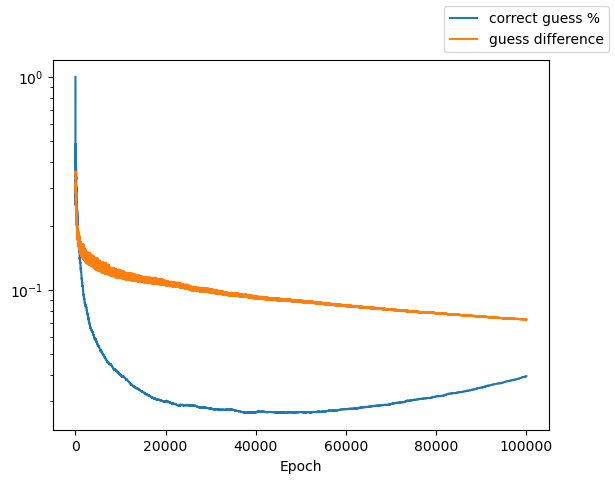

In [18]:
# plot progress stats
x = np.arange(MAX_ITERATIONS)

fig, ax = plt.subplots()

ax.plot(x, good_guess_pct_list, label='correct guess %')
ax.plot(x, guess_diff_list, label='guess difference')

ax.set_yscale('log')
ax.set_xlabel('Epoch')
fig.legend()
if SAVE_FIGS: 
    plt.savefig('images/hill_climbing_progress.jpg')
plt.show()

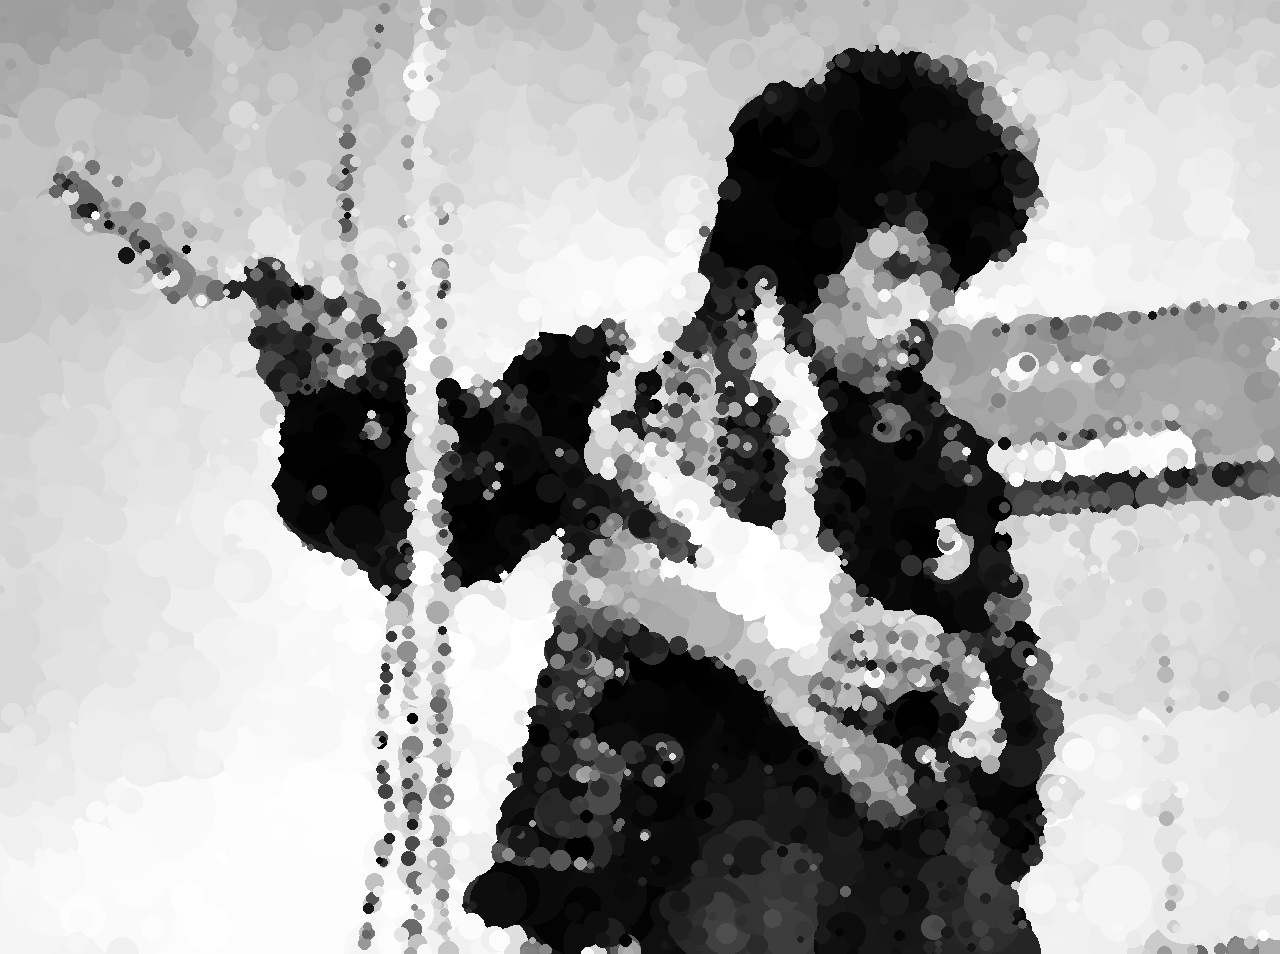

In [19]:
if SAVE_FIGS: 
    im_generated.save('images/jimi_on_guitar.jpg')
im_generated